In [1]:
# MSCI 546 Project:

# Link to the original Kaggle Competition (Real Dataset): https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction

In [2]:

# Libraries

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.optim as optim  # Optimization module

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [3]:
# Synthetic Dataset: https://www.kaggle.com/competitions/playground-series-s4e1/data

# Dataset import
import os
# Set directory to project root
os.chdir('/Users/danazarezankova/Documents/BME 2024/BME 4B/MSCI 546/msci-546-proj')

# Back to root directory
synthetic_train_data = pd.read_csv('data/train.csv')

synthetic_train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
synthetic_train_data.shape

(165034, 14)

In [5]:
# Label encoding for text data:
encoder = LabelEncoder()
categorical_features_train = synthetic_train_data.select_dtypes(include = 'object').columns
print("Categorical features: ", categorical_features_train)
for feature in categorical_features_train:
    synthetic_train_data[feature] = encoder.fit_transform(synthetic_train_data[feature])

# MinMax Scaler for credit score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
synthetic_train_data['CreditScore'] = scaler.fit_transform(synthetic_train_data[['CreditScore']])

# Robust Scaler for Balance
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
synthetic_train_data['Balance'] = scaler.fit_transform(synthetic_train_data[['Balance']])

# MinMax Scaler for Estimated Salary
scaler = MinMaxScaler()
synthetic_train_data['EstimatedSalary'] = scaler.fit_transform(synthetic_train_data[['EstimatedSalary']])

# Age / 100
synthetic_train_data['Age'] = synthetic_train_data['Age'] / 100

synthetic_train_data.drop('id', axis=1, inplace=True)
synthetic_train_data.drop('CustomerId', axis=1, inplace=True)
synthetic_train_data.drop('Surname', axis=1, inplace=True)
synthetic_train_data.dropna(inplace=True)

X = synthetic_train_data.drop('Exited', axis=1)
y = synthetic_train_data['Exited']


Categorical features:  Index(['Surname', 'Geography', 'Gender'], dtype='object')


In [6]:
X.describe()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,0.612909,0.648545,0.564429,0.381259,5.020353,0.462551,1.554455,0.753954,0.497770,0.562870
std,0.160207,0.816574,0.495833,0.088672,2.806159,0.523745,0.547154,0.430707,0.499997,0.251488
min,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.494000,0.000000,0.000000,0.320000,3.000000,0.000000,1.000000,1.000000,0.000000,0.373166
50%,0.618000,0.000000,1.000000,0.370000,5.000000,0.000000,2.000000,1.000000,0.000000,0.589738
75%,0.720000,1.000000,1.000000,0.420000,7.000000,1.000000,2.000000,1.000000,1.000000,0.775779
max,1.000000,2.000000,1.000000,0.920000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000


In [7]:
# Convert the data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = nn.Sequential(
    nn.Linear(10, 20), # 8 input nodes to 12 nodes in the first hidden layer
    nn.ReLU(),        # ReLU activation for first hidden layer
    nn.Linear(20, 10), # 12 nodes from first hidden layer to 8 in the second
    nn.ReLU(),        # ReLU activation for second hidden layer
    nn.Linear(10, 1),  # 8 nodes from second hidden layer to 1 output node
    nn.Sigmoid()      # Sigmoid activation for output layer
)

In [10]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [11]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.38778963685035706, accuracy 0.8219457808693966
Finished epoch 0, latest loss 0.38778963685035706
Finished epoch 1, latest loss 0.339702308177948
Finished epoch 2, latest loss 0.32015523314476013
Finished epoch 3, latest loss 0.31205397844314575
Finished epoch 4, latest loss 0.30723071098327637
Finished epoch 5, latest loss 0.3053268790245056
Finished epoch 6, latest loss 0.3046364486217499
Finished epoch 7, latest loss 0.30337268114089966
Finished epoch 8, latest loss 0.30312302708625793
Finished epoch 9, latest loss 0.3027086853981018
Epoch 10, loss 0.30198904871940613, accuracy 0.8608044402971509
Finished epoch 10, latest loss 0.30198904871940613
Finished epoch 11, latest loss 0.30141323804855347
Finished epoch 12, latest loss 0.3011033833026886
Finished epoch 13, latest loss 0.3009883463382721
Finished epoch 14, latest loss 0.3008527159690857
Finished epoch 15, latest loss 0.2997208833694458
Finished epoch 16, latest loss 0.2999033033847809
Finished epoch 17, latest 

In [13]:
with torch.no_grad():
  y_pred_test = model(X_test)
  
y_pred_50 = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_50)

In [14]:
print(f'Accuracy of the shallow NN model: {accuracy}')

Accuracy of the shallow NN model: 0.8645741812342836


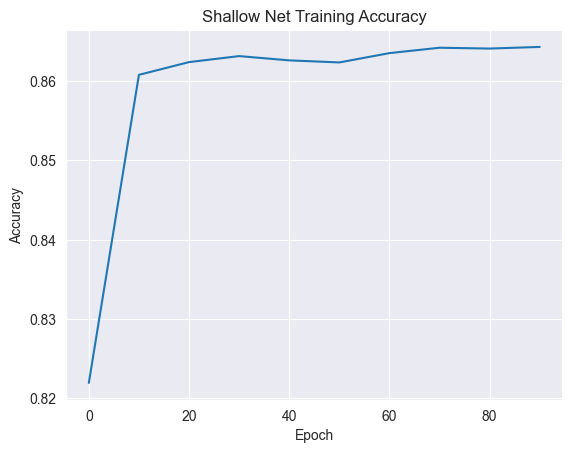

In [15]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Shallow Net Training Accuracy')
plt.show()

AUC:  0.8857137243513306
Precision:  0.7475592747559274
Recall:  0.5394680086268872


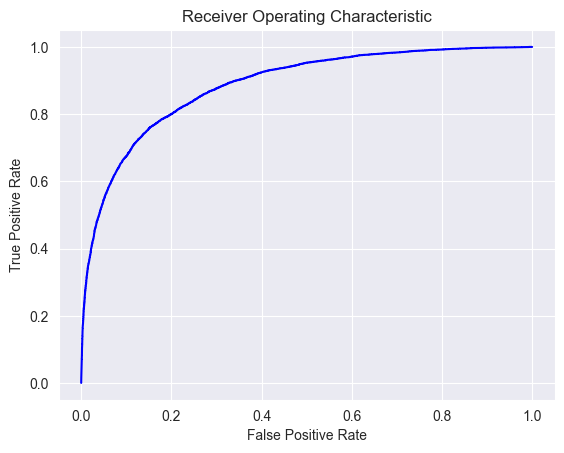

In [16]:
# Making the AUROC curve
import sklearn.metrics as metrics

tpr, fpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
print("AUC: ", roc_auc)

# Precision and recall:
precision = metrics.precision_score(y_test, y_pred_50)
recall = metrics.recall_score(y_test, y_pred_50)
print("Precision: ", precision)
print("Recall: ", recall)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Text(0.5, 427.9555555555555, 'Predicted label')

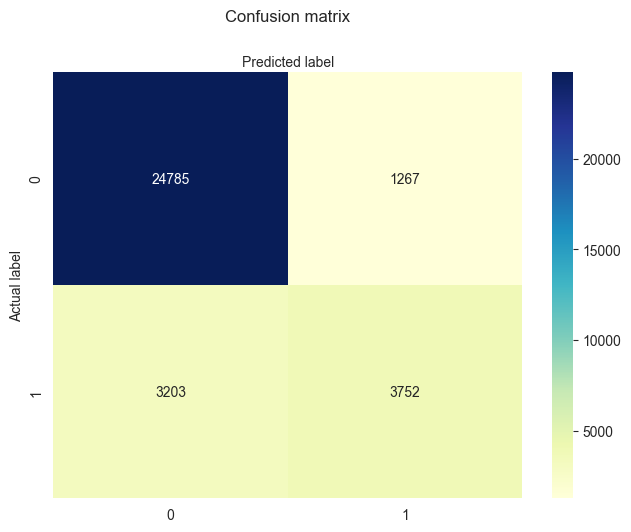

In [17]:
import sklearn.metrics as metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_50)

class_names=[0,1] # Names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')